In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
df = pd.read_csv("../../Datasets/3_earthquake_1995-2023.csv")
df.drop(columns=['title', 'day', 'month', 'year', 'location', 'country'], inplace=True)

Null values in dataset:
magnitude    0
cdi          0
mmi          0
alert        0
tsunami      0
sig          0
net          0
nst          0
dmin         0
gap          0
magType      0
depth        0
latitude     0
longitude    0
continent    0
dtype: int64


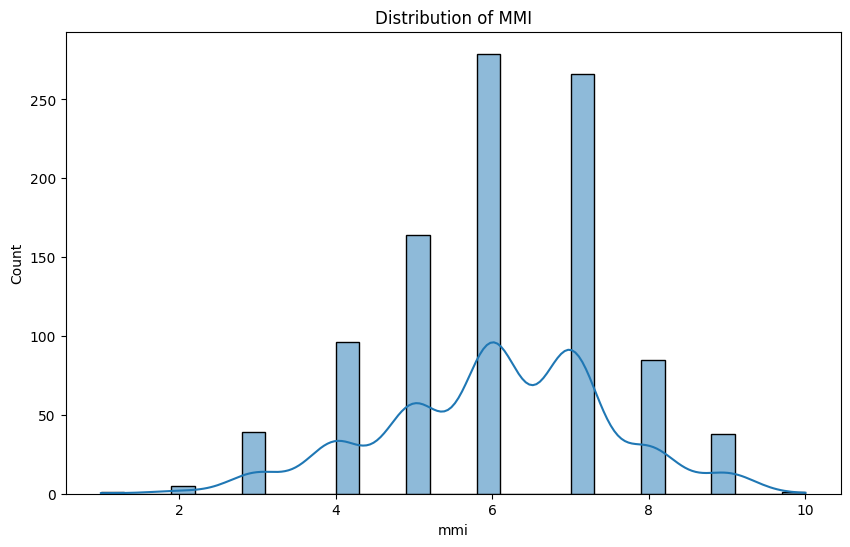

In [12]:
# Check null values and data distribution
print("Null values in dataset:")
print(df.isna().sum())

plt.figure(figsize=(10, 6))
sns.histplot(df['mmi'], kde=True, bins=30)
plt.title('Distribution of MMI')
plt.show()

In [13]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE, SMOTENC, RandomOverSampler
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, cohen_kappa_score, confusion_matrix


In [14]:
# Separate features and target
X = df.drop(columns=['mmi'])
y = df['mmi']

# Identify feature types
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

In [15]:
# Initialize transformers
transformers = {
    'label_encoders': {},
    'scaler': StandardScaler()
}

# Transform categorical features
X_transformed = X.copy()
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

for col in categorical_features:
    transformers['label_encoders'][col] = LabelEncoder()
    X_transformed[col] = transformers['label_encoders'][col].fit_transform(X[col])

# Transform numerical features
X_transformed[numerical_features] = transformers['scaler'].fit_transform(X[numerical_features])

# Transform target (shift values to start from 0)
y_transformed = y - 1  # Subtract 1 from all values to start from 0

In [16]:
# Initialize stratified k-fold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store results
fold_accuracies = []
fold_balanced_accuracies = []
fold_kappa_scores = []
feature_importance_folds = []

# Initialize array for storing predictions for confusion matrix
all_true = []
all_pred = []

# Identify categorical feature indices for SMOTENC
categorical_feature_indices = [i for i, col in enumerate(X_transformed.columns) 
                             if col in categorical_features]

In [17]:
# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=7,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    num_class=len(np.unique(y_transformed)),
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

In [18]:
print("Starting k-fold cross-validation...")
print("Number of unique classes in y_transformed:", len(np.unique(y_transformed)))
print("Unique values in y_transformed:", np.unique(y_transformed))

for fold, (train_idx, val_idx) in enumerate(skf.split(X_transformed, y_transformed), 1):
    print(f"\nFold {fold}/{n_splits}")
    
    # Split data
    X_train, X_val = X_transformed.iloc[train_idx], X_transformed.iloc[val_idx]
    y_train, y_val = y_transformed[train_idx], y_transformed[val_idx]
    
    # Apply RandomOverSampler
    ros = RandomOverSampler(random_state=42)
    X_temp, y_temp = ros.fit_resample(X_train, y_train)
    
    # Apply SMOTENC
    smotenc = SMOTENC(
        categorical_features=categorical_feature_indices,
        random_state=42,
        k_neighbors=2
    )
    X_train_resampled, y_train_resampled = smotenc.fit_resample(X_temp, y_temp)
    
    # Feature selection
    feature_selector = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        num_class=len(np.unique(y_transformed)),
        random_state=42,
        n_jobs=-1
    )
    
    feature_selector.fit(X_train_resampled, y_train_resampled)
    
    # Record feature importance
    fold_importance = pd.DataFrame({
        'Feature': X_transformed.columns,
        'Importance': feature_selector.feature_importances_,
        'Fold': fold
    })
    feature_importance_folds.append(fold_importance)
    
    # Select top features
    selected_features = list(fold_importance.nlargest(10, 'Importance')['Feature'])
    X_train_final = X_train_resampled[selected_features]
    X_val_final = X_val[selected_features]
    
    # Train and evaluate
    eval_set = [(X_val_final, y_val)]
    xgb_model.fit(
        X_train_final,
        y_train_resampled,
        eval_set=eval_set,
        verbose=0
    )
    
    y_pred = xgb_model.predict(X_val_final)
    
    # Store metrics
    fold_accuracies.append(accuracy_score(y_val, y_pred))
    fold_balanced_accuracies.append(balanced_accuracy_score(y_val, y_pred))
    fold_kappa_scores.append(cohen_kappa_score(y_val, y_pred))
    
    all_true.extend(y_val)
    all_pred.extend(y_pred)
    
    # Print fold results
    print(f"\nFold {fold} Results:")
    print(classification_report(y_val, y_pred))

Starting k-fold cross-validation...
Number of unique classes in y_transformed: 10
Unique values in y_transformed: [0 1 2 3 4 5 6 7 8 9]

Fold 1/5

Fold 1 Results:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.55      0.75      0.63         8
           3       0.46      0.55      0.50        20
           4       0.39      0.33      0.36        33
           5       0.52      0.51      0.51        55
           6       0.54      0.53      0.53        53
           7       0.40      0.35      0.38        17
           8       0.40      0.50      0.44         8

    accuracy                           0.48       195
   macro avg       0.41      0.44      0.42       195
weighted avg       0.48      0.48      0.48       195


Fold 2/5

Fold 2 Results:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.60      0.75      0.67       

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4 5 6 7 8], got [1 2 3 4 5 6 7 8 9]

In [ ]:
# Print overall results
print("\nOverall Results:")
print(f"Average Accuracy: {np.mean(fold_accuracies):.4f} (±{np.std(fold_accuracies):.4f})")
print(f"Average Balanced Accuracy: {np.mean(fold_balanced_accuracies):.4f} (±{np.std(fold_balanced_accuracies):.4f})")
print(f"Average Kappa Score: {np.mean(fold_kappa_scores):.4f} (±{np.std(fold_kappa_scores):.4f})")


In [ ]:
# Combine feature importance from all folds
all_feature_importance = pd.concat(feature_importance_folds)
mean_feature_importance = all_feature_importance.groupby('Feature')['Importance'].mean().reset_index()
std_feature_importance = all_feature_importance.groupby('Feature')['Importance'].std().reset_index()


In [ ]:
# Plot average feature importance with error bars
plt.figure(figsize=(12, 8))
top_features = mean_feature_importance.nlargest(10, 'Importance')
plt.errorbar(
    x=top_features['Importance'],
    y=range(len(top_features)),
    xerr=std_feature_importance[std_feature_importance['Feature'].isin(top_features['Feature'])]['Importance'],
    fmt='o',
    capsize=5
)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.title('Top 10 Feature Importance Across Folds')
plt.xlabel('Average Importance (with standard deviation)')
plt.tight_layout()
plt.show()

In [ ]:
# Plot confusion matrix using all predictions
plt.figure(figsize=(12, 8))
cm = confusion_matrix(all_true, all_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            square=True, cbar_kws={"shrink": .5})
plt.title('Confusion Matrix (All Folds)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:
# Plot performance metrics across folds
plt.figure(figsize=(12, 6))
fold_metrics = pd.DataFrame({
    'Fold': range(1, n_splits + 1),
    'Accuracy': fold_accuracies,
    'Balanced Accuracy': fold_balanced_accuracies,
    'Kappa': fold_kappa_scores
})

In [ ]:
fold_metrics_melted = pd.melt(fold_metrics, id_vars=['Fold'], var_name='Metric', value_name='Score')
sns.boxplot(data=fold_metrics_melted, x='Metric', y='Score')
plt.title('Performance Metrics Across Folds')
plt.tight_layout()
plt.show()